# Performing Hausdorff pairs analysis using PSA

In this example, the trajectories have been pre-aligned (as in `psa_short.py` and `psa_short.ipynb`) using the fitting scheme described in:

S.L. Seyler, A. Kumar, M.F. Thorpe, and O. Beckstein, Path
Similarity Analysis: a Method for Quantifying Macromolecular
Pathways. `arXiv:1505.04807v1`_ [q-bio.QM], 2015.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

---
## 1) Set up input data for `PSA` using `MDAnalysis`

In [2]:
from MDAnalysis import Universe
from MDAnalysis.analysis.psa import PSA
from psa_identifier import PSAIdentifier

Initialize lists for the methods on which to perform PSA. PSA will be performed for four different simulations methods with three runs for each: **DIMS**, **FRODA**, **rTMD-F**, and **rTMD-S**. Also initialize a `PSAIdentifier` object to keep track of the data corresponding to comparisons between pairs of simulations.

In [3]:
method_names = ['DIMS', 'FRODA', 'GOdMD', 'MDdMD', 'rTMD-F', 'rTMD-S',
                'ANMP', 'iENM', 'MAP', 'MENM-SD', 'MENM-SP',
                'Morph', 'LinInt']
labels = [] # Heat map labels
simulations = [] # List of simulation topology/trajectory filename pairs
universes = [] # List of MDAnalysis Universes representing simulations

For each method, get the topology and each of three total trajectories (per method). Each simulation is represented as a `(topology, trajectory)` pair of file names, which is appended to a master list of simulations.

In [4]:
for method in method_names:
    # Note: DIMS uses the PSF topology format
    topname = 'top.psf' if 'DIMS' in method or 'TMD' in method else 'top.pdb'
    pathname = 'fitted_psa.dcd'
    method_dir = 'methods/{}'.format(method)
    if method is not 'LinInt':
        for run in xrange(1, 4): # 3 runs per method
            run_dir = '{}/{:03n}'.format(method_dir, run)
            topology = '{}/{}'.format(method_dir, topname)
            trajectory = '{}/{}'.format(run_dir, pathname)
            labels.append(method + '(' + str(run) + ')')
            simulations.append((topology, trajectory))
    else: # only one LinInt trajectory
        topology = '{}/{}'.format(method_dir, topname)
        trajectory = '{}/{}'.format(method_dir, pathname)
        labels.append(method)
        simulations.append((topology, trajectory))

Generate a list of universes from the list of simulations.

In [5]:
for sim in simulations:
    universes.append(Universe(*sim))

---
## 2) Compute and plot nearest neighbor distances using PSA

Initialize a PSA comparison from the universe list using a C$_\alpha$ trajectory representation, then generate `PSA` `Path`s from the universes.

In [7]:
psa_hpa = PSA(universes, path_select='name CA', labels=labels)
psa_hpa.generate_paths()

### Compute full Hausdorff pairs analysis for all unique pairs of paths

Generate the Hausdorff nearest neighbors and Hausdorff pairs (frames and distances)

In [8]:
psa_hpa.run_hausdorff_pairs_analysis(neighbors=True, hausdorff_pairs=True)

Plot clustered heat maps using Ward hierarchical clustering. The first heat map is plotted with the corresponding dendrogram and is fully labeled by the method names; the second heat map is annotated by the Hausdorff distances.

### Use PSA IDs to obtain data for the comparisons we want
Get the Simulation IDs and PSA ID for the second DIMS simulation (DIMS 2) and third rTMD-F simulation (rTMD-F 3).

**Note**: The comparison between a pair of simulations is assigned a unique PSA ID. Given the order in which simulations are added to PSA, the comparison between a pair of simulations can be identified by (distance) matrix indices. The PSA ID is the index in the corresponding distance vector of a given pair of simulations.

In [9]:
psa_id = PSAIdentifier()
for name in method_names:
    run_ids = [1] if 'LinInt' in name else [1,2,3]
    psa_id.add_sim(name, run_ids)

In [10]:
sim1, sim2, sim3 = 'DIMS 1', 'DIMS 2', 'rTMD-F 3'
ID1 = psa_id.get_psa_id(sim1, sim2)
ID2 = psa_id.get_psa_id(sim2, sim3)

Plotting nearest neighbors as a function of normalized progress frame for:

DIMS 1 and DIMS 2

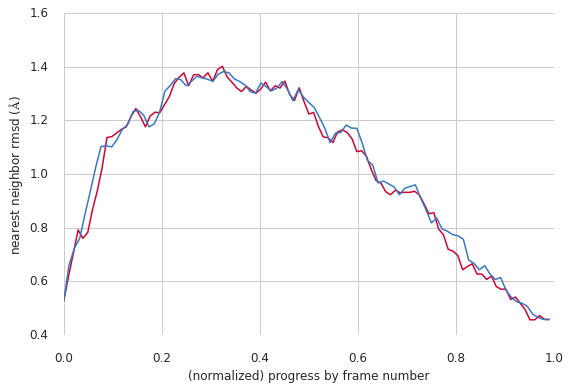

In [11]:
psa_hpa.plot_nearest_neighbors(filename='nn_dims1_dims2.pdf', idx=ID1)

DIMS 1 and rTMD-F 3

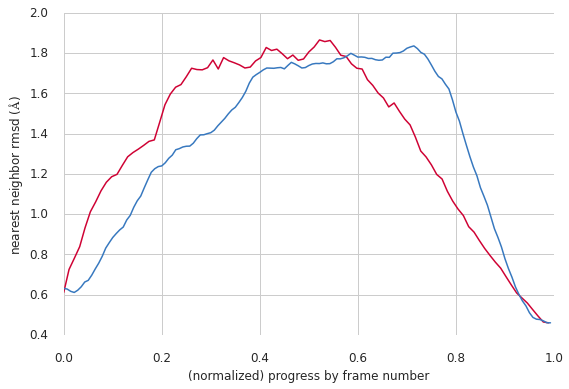

In [12]:
psa_hpa.plot_nearest_neighbors(filename='nn_dims2_tmds3.pdf', idx=ID2)